In [1]:
!pip install ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.6/913.6 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [2]:
!pip install -qU ultralytics roboflow


In [3]:
from roboflow import Roboflow

rf = Roboflow(api_key="5awECAQIXbkGZdtEi4EG")  # Replace with your API key
project = rf.workspace("cvproject-h3foy").project("rock-paper_scissors-object-detection-mahan-erfan-shayan")  # Use your new dataset
version = project.version(3)
dataset = version.download("yolov11")

print("Dataset location:", dataset.location)


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rock-Paper_Scissors-object-detection-(Mahan,-Erfan,-Shayan)-3 in yolov11:: 100%|██████████| 36169/36169 [00:04<00:00, 8838.69it/s] 

Dataset location: /kaggle/working/Rock-Paper_Scissors-object-detection-(Mahan,-Erfan,-Shayan)-3


In [4]:
print("Dataset downloaded to:", dataset.location)


Dataset downloaded to: /kaggle/working/Rock-Paper_Scissors-object-detection-(Mahan,-Erfan,-Shayan)-3


In [5]:
with open(dataset.location + "/data.yaml", "r") as f:
    print(f.read())


train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['paper', 'rock', 'scissors']

roboflow:
  workspace: cvproject-h3foy
  project: rock-paper_scissors-object-detection-mahan-erfan-shayan
  version: 3
  license: CC BY 4.0
  url: https://universe.roboflow.com/cvproject-h3foy/rock-paper_scissors-object-detection-mahan-erfan-shayan/dataset/3


In [6]:
import os

# List files in the train/images folder
train_images_path = os.path.join(dataset.location, "train/images")
image_files = os.listdir(train_images_path)

print(f"Found {len(image_files)} images in the training dataset.")
print("Example images:", image_files[:5])  # Display first 5 image filenames


Found 17314 images in the training dataset.
Example images: ['IMG_2F0E68C1CD46-104_jpeg.rf.718a86b5a05a1fdf5c7208e4025ef7e7.jpg', 'sample2_mp4-0053_jpg.rf.b0a12efa11f9ec7b64adb3a38f3d64a9.jpg', 'IMG_5636_MOV-16_jpg.rf.a2f9483177a92e52c452ef46e7618c3d.jpg', 'Screen-Recording-2023-03-11-at-9_48_18-PM_mov-262_jpg.rf.c9f61e3c935e2a558da3e35387b59cf4.jpg', 'PXL_20250127_141322159_mp4-0250_jpg.rf.dfd6d43b3c6945bcddef5a2239b3ef0b.jpg']


Displaying image: IMG_2F0E68C1CD46-104_jpeg.rf.718a86b5a05a1fdf5c7208e4025ef7e7.jpg


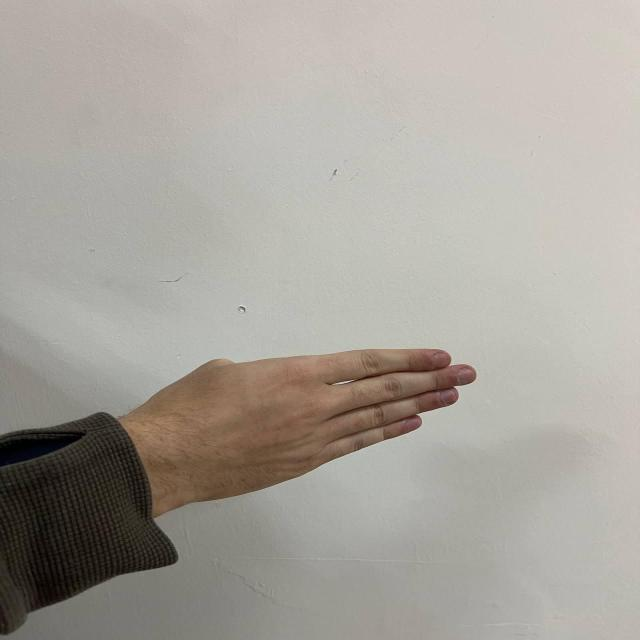

In [7]:
from google.colab.patches import cv2_imshow
import cv2

# Display the first image in the training dataset
image_path = os.path.join(train_images_path, image_files[0])  # Use the first image from the list
image = cv2.imread(image_path)

if image is not None:
    print("Displaying image:", image_files[0])
    cv2_imshow(image)
else:
    print("Failed to load image:", image_path)


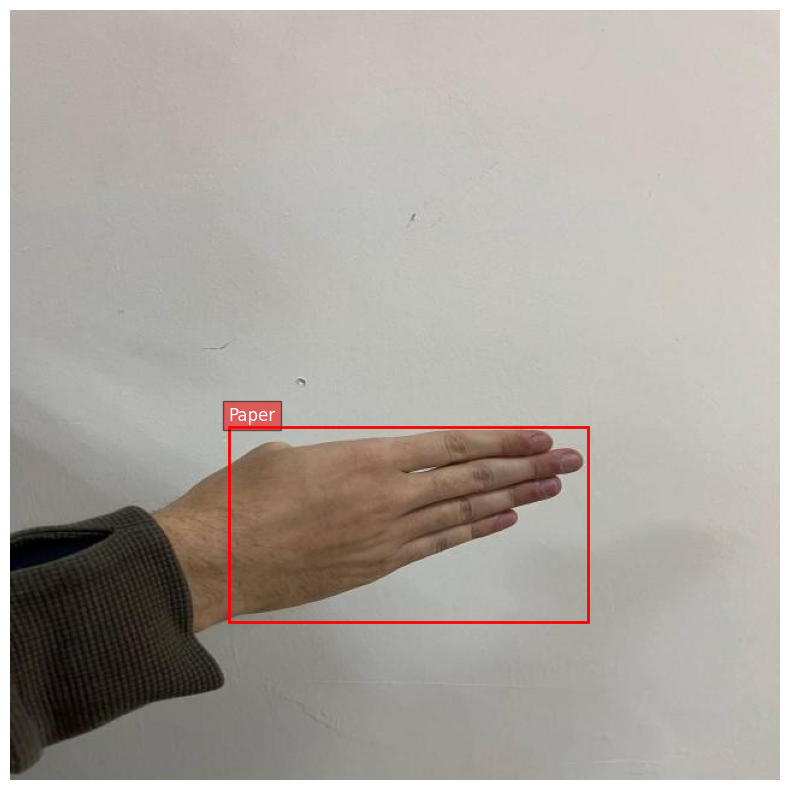

In [8]:
import matplotlib.pyplot as plt

def plot_bounding_boxes(image_path, label_path, class_names):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

    # Load the labels
    with open(label_path, "r") as f:
        labels = f.readlines()

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # Add bounding boxes
    h, w, _ = image.shape
    for label in labels:
        class_id, x_center, y_center, box_width, box_height = map(float, label.split())
        x_center, y_center, box_width, box_height = (
            x_center * w, y_center * h, box_width * w, box_height * h
        )
        x_min = x_center - box_width / 2
        y_min = y_center - box_height / 2

        # Draw the rectangle
        rect = plt.Rectangle(
            (x_min, y_min), box_width, box_height, linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)
        # Add class label
        plt.text(
            x_min,
            y_min - 5,
            class_names[int(class_id)],
            color="white",
            fontsize=12,
            bbox=dict(facecolor="red", alpha=0.5),
        )

    plt.axis("off")
    plt.show()

# Example usage
class_names = ["Paper", "Rock", "Scissors"]
label_path = os.path.join(dataset.location, "train/labels", image_files[0].replace(".jpg", ".txt"))
plot_bounding_boxes(image_path, label_path, class_names)


In [9]:
from collections import Counter

def get_class_distribution(label_dir):
    class_counts = Counter()

    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), "r") as f:
            labels = f.readlines()
            for label in labels:
                class_id = int(label.split()[0])
                class_counts[class_id] += 1

    return class_counts

label_dir = os.path.join(dataset.location, "train/labels")
class_distribution = get_class_distribution(label_dir)

# Map class IDs to names
class_distribution_named = {class_names[k]: v for k, v in class_distribution.items()}
print("Class Distribution:", class_distribution_named)


Class Distribution: {'Paper': 5020, 'Rock': 9044, 'Scissors': 5636}


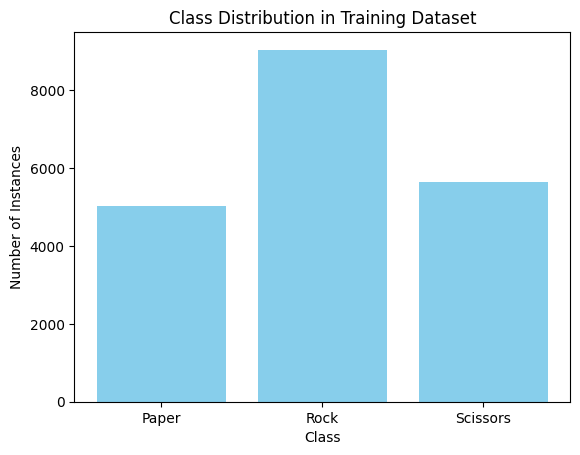

In [10]:
import matplotlib.pyplot as plt

# Plot class distribution
plt.bar(class_distribution_named.keys(), class_distribution_named.values(), color="skyblue")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.title("Class Distribution in Training Dataset")
plt.show()


In [11]:
from ultralytics import YOLO
import os


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [12]:
# ✅ Define Model Path
model_path = "/kaggle/input/pretrained_rpc_v1/pytorch/default/1/yolo11-rps-detection.pt"

# ✅ Manually Set Dataset YAML Path (since it's downloaded dynamically)
dataset_yaml_path = "/kaggle/working/Rock-Paper_Scissors-object-detection-(Mahan,-Erfan,-Shayan)-3/data.yaml"

# ✅ Verify Model Path
if os.path.exists(model_path):
    print(f"✅ Pre-trained model found: {model_path}")
else:
    print(f"❌ ERROR: Pre-trained model NOT found at: {model_path}")
    print("🔎 Listing available files in model directory:")
    print(os.listdir(os.path.dirname(model_path)))  # Debugging

# ✅ Verify Dataset Path
if os.path.exists(dataset_yaml_path):
    print(f"✅ Dataset YAML found: {dataset_yaml_path}")
else:
    print(f"❌ ERROR: Dataset YAML NOT found at: {dataset_yaml_path}")
    print("🔎 Listing available files in dataset directory:")
    print(os.listdir(os.path.dirname(dataset_yaml_path)))  # Debugging)


✅ Pre-trained model found: /kaggle/input/pretrained_rpc_v1/pytorch/default/1/yolo11-rps-detection.pt
✅ Dataset YAML found: /kaggle/working/Rock-Paper_Scissors-object-detection-(Mahan,-Erfan,-Shayan)-3/data.yaml


In [13]:
# Load the pre-trained model
model = YOLO(model_path)

In [14]:
# Train the model
results = model.train(
    data=dataset_yaml_path,  
    epochs=80,               
    imgsz=640,             
    batch=64,                
    name="yolo11n_finetuned", 
    val=True,
    plots=True
)

Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/pretrained_rpc_v1/pytorch/default/1/yolo11-rps-detection.pt, data=/kaggle/working/Rock-Paper_Scissors-object-detection-(Mahan,-Erfan,-Shayan)-3/data.yaml, epochs=80, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11n_finetuned, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

100%|██████████| 755k/755k [00:00<00:00, 26.3MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 5.35M/5.35M [00:00<00:00, 94.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/Rock-Paper_Scissors-object-detection-(Mahan,-Erfan,-Shayan)-3/train/labels... 17314 images, 3366 backgrounds, 0 corrupt: 100%|██████████| 17314/17314 [00:13<00:00, 1258.61it/s]


train: New cache created: /kaggle/working/Rock-Paper_Scissors-object-detection-(Mahan,-Erfan,-Shayan)-3/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 332, len(boxes) = 19700. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /kaggle/working/Rock-Paper_Scissors-object-detection-(Mahan,-Erfan,-Shayan)-3/valid/labels... 766 images, 223 backgrounds, 0 corrupt: 100%|██████████| 766/766 [00:01<00:00, 756.08it/s]

val: New cache created: /kaggle/working/Rock-Paper_Scissors-object-detection-(Mahan,-Erfan,-Shayan)-3/valid/labels.cache


Plotting labels to runs/detect/yolo11n_finetuned/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolo11n_finetuned
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      9.09G      1.294      1.422      1.443         75        640: 100%|██████████| 271/271 [02:49<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

                   all        766        778      0.867      0.819      0.891      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80       9.1G      1.186      1.069      1.324         69        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        766        778      0.738      0.573      0.648       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      9.09G      1.208      1.071      1.325         90        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

                   all        766        778      0.747      0.671      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      9.04G      1.233      1.118      1.337         59        640: 100%|██████████| 271/271 [02:48<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]

                   all        766        778      0.836      0.709      0.804      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      9.16G      1.187      1.056      1.311         87        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all        766        778      0.801      0.818      0.862      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      9.09G      1.156      1.003      1.292         58        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all        766        778      0.847      0.802      0.876       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      9.09G       1.14      0.965      1.276         64        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all        766        778      0.816      0.825       0.88      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      9.09G      1.114     0.9285      1.256         77        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]

                   all        766        778      0.866      0.864      0.906      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      9.09G      1.086     0.8854       1.24         60        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

                   all        766        778       0.88      0.864      0.926      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80       9.1G      1.074     0.8698      1.233         85        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        766        778      0.902      0.899      0.939      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      9.09G      1.045     0.8341      1.217         54        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

                   all        766        778      0.906      0.881      0.939      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      9.04G      1.037     0.8289      1.208         87        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all        766        778        0.9      0.921      0.948      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      9.09G      1.029     0.8135      1.208         66        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]

                   all        766        778      0.874      0.889      0.925      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      9.09G      1.012     0.7941      1.195         79        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all        766        778      0.921       0.92      0.948      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      9.09G      1.004     0.7764      1.188         77        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

                   all        766        778      0.912       0.93      0.958       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      9.04G     0.9941     0.7666      1.188         63        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

                   all        766        778      0.887      0.934      0.954      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      9.09G     0.9801     0.7487      1.175         49        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

                   all        766        778      0.912       0.93      0.959       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80       9.1G     0.9782     0.7484      1.176         67        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

                   all        766        778      0.904       0.92      0.954      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      9.09G     0.9775     0.7333      1.173         80        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all        766        778      0.931      0.914      0.962      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      9.09G     0.9612     0.7166      1.161         72        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]

                   all        766        778      0.914      0.937      0.966      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      9.09G     0.9545     0.7123      1.157         59        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]

                   all        766        778      0.916      0.941      0.961      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      9.09G     0.9525     0.7049      1.156         85        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]

                   all        766        778      0.914      0.946      0.966      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      9.04G     0.9378     0.6931      1.148         86        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

                   all        766        778      0.914      0.952      0.967      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      9.09G     0.9398     0.6885       1.15         77        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        766        778      0.933      0.935      0.962      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      9.09G     0.9345      0.678      1.148         65        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all        766        778      0.935       0.96      0.971      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      9.09G     0.9263     0.6739      1.142         70        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all        766        778      0.936      0.951      0.971      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      9.04G     0.9233     0.6661      1.142         65        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]

                   all        766        778      0.932      0.944      0.967      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      9.09G     0.9098     0.6622      1.133         65        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all        766        778      0.937      0.946      0.967      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      9.09G     0.9069     0.6519      1.131         68        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all        766        778      0.938       0.95       0.97      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80       9.1G     0.9037     0.6512      1.132         71        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all        766        778      0.935      0.956      0.973      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80       9.1G     0.9032     0.6466       1.13         70        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all        766        778       0.94      0.949      0.968      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      9.09G     0.8942     0.6301      1.125         58        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all        766        778      0.945      0.931       0.97      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80       9.1G     0.8904     0.6295      1.119         75        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        766        778      0.945      0.947      0.973      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      9.09G     0.8858     0.6226      1.118         59        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all        766        778      0.944      0.949      0.973      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      9.09G     0.8811     0.6188      1.116         68        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]

                   all        766        778      0.938      0.954      0.976      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      9.09G     0.8744     0.6121      1.112         88        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

                   all        766        778      0.933      0.961      0.972      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      9.09G      0.873     0.6127       1.11         58        640: 100%|██████████| 271/271 [02:46<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        766        778      0.948      0.952      0.976      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      9.04G     0.8639     0.5974      1.106         61        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]

                   all        766        778      0.943      0.957      0.975      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      9.09G     0.8615     0.5988      1.105         56        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]

                   all        766        778      0.938      0.955      0.975       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      9.11G      0.856     0.5922      1.103         60        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all        766        778      0.947      0.947      0.973      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      9.09G     0.8551     0.5876      1.103         66        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all        766        778       0.94      0.962      0.975       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      9.09G     0.8489     0.5838        1.1         87        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

                   all        766        778      0.943      0.958      0.974      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80       9.1G     0.8457      0.581      1.093         81        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]

                   all        766        778      0.947      0.954      0.976      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      9.09G     0.8423     0.5763      1.092         76        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all        766        778      0.949      0.958      0.977      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80       9.1G     0.8403     0.5683       1.09         63        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all        766        778      0.945      0.953      0.978      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      9.04G     0.8329     0.5604      1.089         80        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]

                   all        766        778      0.951      0.951      0.979      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      9.04G     0.8277     0.5619      1.085         67        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all        766        778      0.945      0.963      0.979      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      9.09G      0.826     0.5551      1.085         72        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all        766        778      0.947      0.961      0.979      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      9.04G     0.8221     0.5551       1.08         75        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]

                   all        766        778      0.946      0.964      0.979      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      9.09G     0.8128     0.5405      1.077         61        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all        766        778      0.948      0.956      0.979      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      9.04G     0.8121     0.5431      1.079         80        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all        766        778      0.952      0.957      0.978       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      9.09G       0.81     0.5424      1.079         76        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]

                   all        766        778      0.959      0.954      0.981      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80       9.1G     0.8047     0.5348      1.073         72        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]

                   all        766        778      0.951      0.957      0.979      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      9.04G     0.8021     0.5281      1.074         71        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all        766        778       0.95       0.96      0.978       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80       9.1G      0.798     0.5329      1.075         63        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all        766        778      0.951      0.961      0.978      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      9.09G     0.7939     0.5245      1.071         76        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all        766        778      0.949       0.96      0.979       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      9.09G     0.7848     0.5138      1.062         63        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all        766        778      0.949      0.963      0.979      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      9.09G     0.7863     0.5127      1.063         89        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all        766        778      0.948      0.964      0.979       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      9.04G     0.7742     0.5086      1.061         78        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        766        778      0.949      0.965      0.979      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      9.09G     0.7769     0.5084      1.061         66        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

                   all        766        778      0.949      0.964      0.979      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      9.09G     0.7681     0.4988      1.057         76        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all        766        778      0.951      0.962      0.978      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      9.09G     0.7648     0.4937      1.056         70        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

                   all        766        778      0.951      0.963      0.978      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80       9.1G     0.7658     0.4925      1.054         73        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        766        778      0.951      0.963      0.978      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80       9.1G     0.7591     0.4869      1.051         53        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all        766        778      0.951      0.963      0.979      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80       9.1G     0.7512     0.4839      1.047         74        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        766        778      0.951      0.963      0.979      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      9.04G     0.7497     0.4781      1.045         63        640: 100%|██████████| 271/271 [02:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all        766        778      0.951      0.963      0.979      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      9.09G     0.7454      0.477      1.046         70        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        766        778      0.952      0.962      0.979      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80       9.1G     0.7414     0.4718      1.045         77        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

                   all        766        778      0.953      0.963      0.979      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      9.09G     0.7345     0.4654      1.041         67        640: 100%|██████████| 271/271 [02:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        766        778      0.954      0.963      0.979      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80       9.1G      0.729     0.4596      1.034         86        640: 100%|██████████| 271/271 [02:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all        766        778      0.954      0.963      0.979      0.845


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      9.04G     0.6564      0.304     0.9973         36        640: 100%|██████████| 271/271 [02:49<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all        766        778      0.955      0.963      0.979      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      9.04G     0.6453     0.2976     0.9917         30        640: 100%|██████████| 271/271 [02:46<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all        766        778      0.956      0.963      0.979      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      9.04G     0.6329     0.2911     0.9835         37        640: 100%|██████████| 271/271 [02:46<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

                   all        766        778      0.956      0.962      0.979      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      9.04G     0.6212     0.2838     0.9775         42        640: 100%|██████████| 271/271 [02:46<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all        766        778      0.956      0.962      0.979      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      9.04G      0.619     0.2833     0.9781         38        640: 100%|██████████| 271/271 [02:46<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all        766        778      0.957      0.962      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      9.04G     0.6061     0.2759     0.9696         36        640: 100%|██████████| 271/271 [02:46<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

                   all        766        778      0.957      0.962       0.98      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      9.04G     0.6022     0.2726     0.9686         35        640: 100%|██████████| 271/271 [02:46<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all        766        778      0.958      0.962       0.98      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      9.04G     0.5981     0.2704     0.9646         28        640: 100%|██████████| 271/271 [02:46<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        766        778      0.957      0.962       0.98      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      9.04G     0.5884     0.2651     0.9624         38        640: 100%|██████████| 271/271 [02:46<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]

                   all        766        778      0.957      0.962       0.98      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      9.04G     0.5815     0.2615     0.9576         33        640: 100%|██████████| 271/271 [02:46<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]

                   all        766        778      0.958      0.962       0.98      0.848



80 epochs completed in 3.831 hours.
Optimizer stripped from runs/detect/yolo11n_finetuned/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11n_finetuned/weights/best.pt, 5.5MB

Validating runs/detect/yolo11n_finetuned/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


                   all        766        778      0.958      0.962       0.98      0.848
                 paper        185        189      0.971      0.958      0.978      0.863
                  rock        265        351      0.931      0.962      0.974      0.806
              scissors        208        238       0.97      0.965      0.989      0.876


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/yolo11n_finetuned


In [15]:
# from ultralytics import YOLO
# import os
# import shutil
# from IPython.display import Image

# # ✅ Find latest experiment folder in 'runs/detect/'
# runs_dir = "runs/detect/"
# experiment_folders = os.listdir(runs_dir)
# experiment_path = os.path.join(runs_dir, experiment_folders[-1])  # Get latest run folder

# print(f"🔍 Training results stored in: {experiment_path}")

# # ✅ Locate the trained model's .pt file
# trained_model_path = os.path.join(experiment_path, "weights", "best.pt")

# # ✅ Copy the trained model to Kaggle working directory for easy access
# saved_model_path = "/kaggle/working/yolo11n_finetuned.pt"
# shutil.copy(trained_model_path, saved_model_path)

# print(f"✅ Model saved at: {saved_model_path}")

In [16]:
# Image(filename=os.path.join(experiment_path, "results.png"), width=1200)


In [17]:
# Image(filename=os.path.join(experiment_path, "confusion_matrix_normalized.png"), width=1000)


In [18]:
# Image(filename=os.path.join(experiment_path, "PR_curve.png"), width=600)


In [19]:
# Image(filename=os.path.join(experiment_path, "labels.jpg"), width=600)

In [20]:
# Image(filename="runs/detect/yolo11n_finetuned/PR_curve.png", width=600)


In [21]:
# Image(filename="runs/detect/yolo11n_finetuned/labels.jpg", width=600)